# Differential Privacy 

In [24]:
import pandas as pd
import numpy as np

# Load the NHANES demo dataset from XPT (SAS transport format)
file_path = "DEMO_L.xpt"
df = pd.read_sas(file_path, format='xport')

# Show basic information and save to CSV for further use
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      11933 non-null  float64
 1   SDDSRVYR  11933 non-null  float64
 2   RIDSTATR  11933 non-null  float64
 3   RIAGENDR  11933 non-null  float64
 4   RIDAGEYR  11933 non-null  float64
 5   RIDAGEMN  377 non-null    float64
 6   RIDRETH1  11933 non-null  float64
 7   RIDRETH3  11933 non-null  float64
 8   RIDEXMON  8860 non-null   float64
 9   RIDEXAGM  2787 non-null   float64
 10  DMQMILIZ  8301 non-null   float64
 11  DMDBORN4  11914 non-null  float64
 12  DMDYRUSR  1875 non-null   float64
 13  DMDEDUC2  7794 non-null   float64
 14  DMDMARTZ  7792 non-null   float64
 15  RIDEXPRG  1503 non-null   float64
 16  DMDHHSIZ  11933 non-null  float64
 17  DMDHRGND  4115 non-null   float64
 18  DMDHRAGZ  4124 non-null   float64
 19  DMDHREDZ  3746 non-null   float64
 20  DMDHRMAZ  4020 non-null   fl

(None,
        SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
 0  130378.0      12.0       2.0       1.0      43.0       NaN       5.0   
 1  130379.0      12.0       2.0       1.0      66.0       NaN       3.0   
 2  130380.0      12.0       2.0       2.0      44.0       NaN       2.0   
 3  130381.0      12.0       2.0       2.0       5.0       NaN       5.0   
 4  130382.0      12.0       2.0       1.0       2.0       NaN       3.0   
 
    RIDRETH3  RIDEXMON  RIDEXAGM  ...  DMDHRGND  DMDHRAGZ  DMDHREDZ  DMDHRMAZ  \
 0       6.0       2.0       NaN  ...       NaN       NaN       NaN       NaN   
 1       3.0       2.0       NaN  ...       NaN       NaN       NaN       NaN   
 2       2.0       1.0       NaN  ...       NaN       NaN       NaN       NaN   
 3       7.0       1.0      71.0  ...       2.0       2.0       2.0       3.0   
 4       3.0       2.0      34.0  ...       2.0       2.0       3.0       1.0   
 
    DMDHSEDZ      WTINT2YR      WTMEC2YR  SDMVS

In [22]:
# Save the dataset as CSV for further processing and public reference
csv_path = "DEMO_L.csv"
df.to_csv(csv_path, index=False)

### Load and Explore the Data

We extracted two sensitive features from the NHANES dataset as an example:
- RIDAGEYR: Respondent's age in years
- INDFMPIR: Ratio of family income to poverty threshold

In [25]:
# Select only the columns of interest and drop missing values
df_filtered = df[['RIDAGEYR', 'INDFMPIR']].dropna()
df_filtered.describe()

,RIDAGEYR,INDFMPIR
count,9.892000e+03,9.892000e+03
mean,3.833937e+01,2.708174e+00
std,2.544978e+01,1.670119e+00
min,5.397605e-79,5.397605e-79
25%,1.400000e+01,1.180000e+00
50%,3.750000e+01,2.500000e+00
75%,6.200000e+01,4.500000e+00
max,8.000000e+01,5.000000e+00


## DP a simple example Using Laplace Mechanism

In [26]:
# Define Laplace mechanism function
def laplace_mechanism(value, sensitivity, epsilon):
    """Applies Laplace noise to a statistic."""
    noise = np.random.laplace(loc=0, scale=sensitivity / epsilon)
    return value + noise

# Calculate true means
true_mean_age = df_filtered['RIDAGEYR'].mean()
true_mean_income = df_filtered['INDFMPIR'].mean()

# Define sensitivity (range divided by n)
age_range = df_filtered['RIDAGEYR'].max() - df_filtered['RIDAGEYR'].min()
income_range = df_filtered['INDFMPIR'].max() - df_filtered['INDFMPIR'].min()
n = len(df_filtered)

sensitivity_age = age_range / n
sensitivity_income = income_range / n

# Try different epsilons
epsilons = [0.1, 0.5, 1.0, 5.0]
dp_results = []

for eps in epsilons:
    dp_mean_age = laplace_mechanism(true_mean_age, sensitivity_age, eps)
    dp_mean_income = laplace_mechanism(true_mean_income, sensitivity_income, eps)
    dp_results.append((eps, dp_mean_age, dp_mean_income))

dp_df = pd.DataFrame(dp_results, columns=['Epsilon', 'DP Mean Age', 'DP Mean Income Ratio'])
dp_df

,Epsilon,DP Mean Age,DP Mean Income Ratio
0,0.1,38.242692,2.712323
1,0.5,38.330941,2.708479
2,1.0,38.353694,2.707413
3,5.0,38.339433,2.708182


Here are the Differentially Private Mean Estimates of age and income ratio using the Laplace mechanism with different ε (privacy budget) values.
- Smaller ε = Stronger privacy, more noise.
- Larger ε = Weaker privacy, less noise.

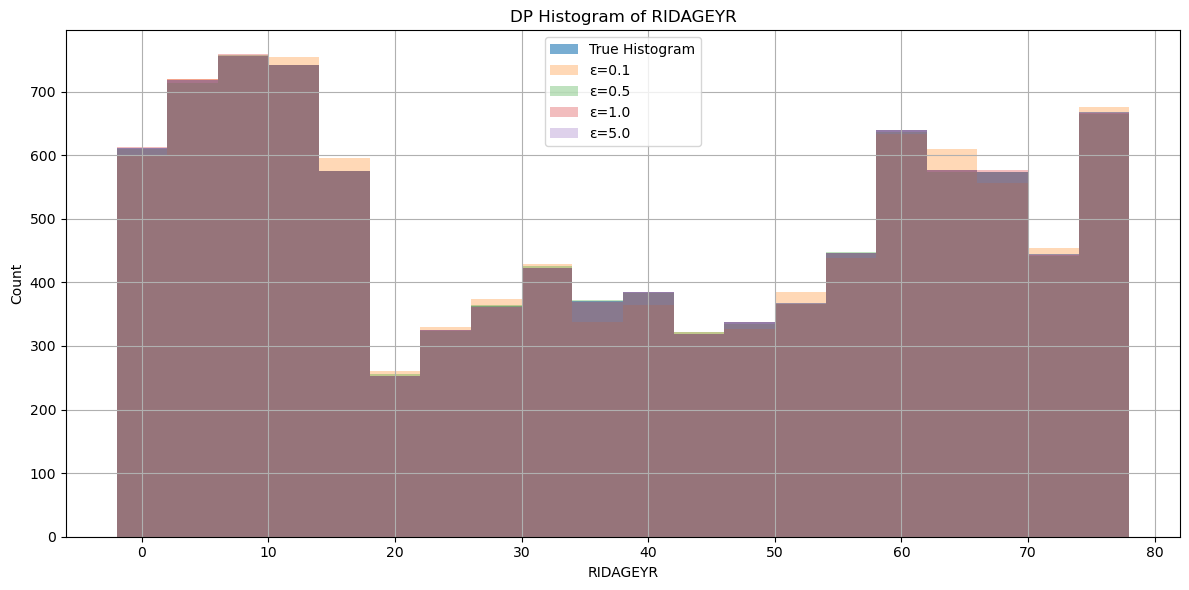

In [27]:
import matplotlib.pyplot as plt

# Plot histogram of true values vs. DP histograms
def plot_dp_histograms(data, column, epsilon_values, bins=20):
    true_hist, bin_edges = np.histogram(data[column], bins=bins, range=(data[column].min(), data[column].max()))
    bin_width = bin_edges[1] - bin_edges[0]
    sensitivity = 1.0  # 1 count per bin

    plt.figure(figsize=(12, 6))
    plt.bar(bin_edges[:-1], true_hist, width=bin_width, alpha=0.6, label='True Histogram')

    for eps in epsilon_values:
        noisy_hist = [laplace_mechanism(count, sensitivity, eps) for count in true_hist]
        plt.bar(bin_edges[:-1], noisy_hist, width=bin_width, alpha=0.3, label=f'ε={eps}')

    plt.title(f'DP Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Apply to age
plot_dp_histograms(df_filtered, 'RIDAGEYR', epsilon_values=[0.1, 0.5, 1.0, 5.0])


This plot shows a differentially private histogram of age (RIDAGEYR) using the Laplace mechanism at various ε levels:
- The blue bars show the true counts.
- The lighter bars show noisy counts at different ε values (0.1, 0.5, 1.0, 5.0).
Note that:
- At ε = 0.1, privacy is strong, but noise is high — patterns are distorted.
- At ε = 5.0, privacy is weaker, but the histogram closely resembles the original.


## Using diffprivlib for Differential Privacy in Healthcare Data
diffprivlib is a Python library developed by IBM that provides out-of-the-box differential privacy mechanisms. It supports scikit-learn-style models and statistical functions, making it easy to integrate into existing Python data analysis workflows.

### Example Private Mean of Age and Income with diffprivlib
Make sure to install diffprivlib using:

"pip install diffprivlib"

In [28]:
from diffprivlib.tools import mean as dp_mean

# Prepare clipped data
age_data = df_filtered['RIDAGEYR'].clip(lower=0, upper=80).to_numpy()
income_data = df_filtered['INDFMPIR'].clip(lower=0, upper=5).to_numpy()

# Evaluate DP means using diffprivlib for multiple epsilon values
dp_lib_results = []
epsilons = [0.1, 0.5, 1.0, 5.0]

for eps in epsilons:
    dp_age = dp_mean(age_data, epsilon=eps, bounds=(0, 80))
    dp_income = dp_mean(income_data, epsilon=eps, bounds=(0, 5))
    dp_lib_results.append((eps, dp_age, dp_income))

dp_lib_df = pd.DataFrame(dp_lib_results, columns=['Epsilon', 'DP Mean Age (diffprivlib)', 'DP Mean Income (diffprivlib)'])
dp_lib_df

,Epsilon,DP Mean Age (diffprivlib),DP Mean Income (diffprivlib)
0,0.1,38.632180,2.694409
1,0.5,38.324056,2.709143
2,1.0,38.347700,2.707702
3,5.0,38.334561,2.708010


### Differentially Private Median (Quantile Analysis)

### Example Histogram on the gender variable (RIAGENDR) 

In [29]:
# Extract the 'RIAGENDR' column (1 = Male, 2 = Female)
gender_data = df['RIAGENDR'].dropna().astype(int).to_numpy()

# Define epsilon values for differential privacy
epsilons = [0.1, 0.5, 1.0, 5.0]

# Store results for each epsilon
dp_histograms = []

for eps in epsilons:
    # Compute differentially private histogram
    hist, bin_edges = histogram(gender_data, epsilon=eps, range=(1, 3), bins=2)
    dp_histograms.append((eps, hist))


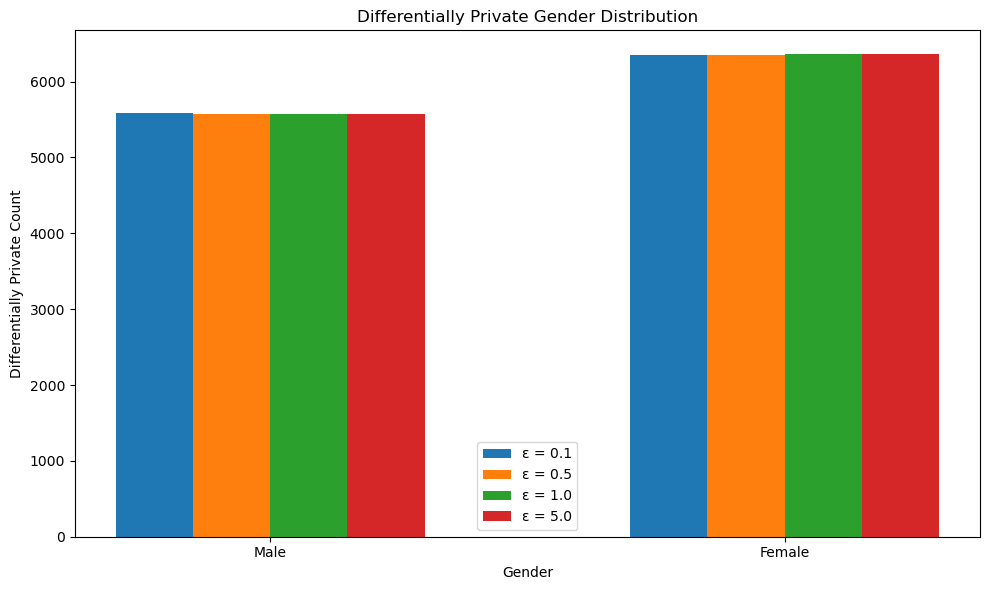

In [30]:
# Labels for genders
labels = ['Male', 'Female']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar
bar_width = 0.15

# Positions of bars on x-axis
r = np.arange(len(labels))

for i, (eps, hist) in enumerate(dp_histograms):
    # Position of bars for this epsilon
    positions = r + i * bar_width
    ax.bar(positions, hist, width=bar_width, label=f'ε = {eps}')

# Labels and title
ax.set_xlabel('Gender')
ax.set_ylabel('Differentially Private Count')
ax.set_title('Differentially Private Gender Distribution')
ax.set_xticks(r + bar_width * (len(epsilons) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()
